# Synaptic Partner Prediction in FAFB

Analysis and visualization code to work with the synaptic partner predictions from Buhmann et al. 2019 and neuron
segmentation from Li et al. 2019.

November 2019, Stephan Gerhard <info@braincircuits.io> (Modified by Julia Buhmann - December 2019)

### Prerequisites

* Download the SQLite database dump of all synaptic partner predictions and store it locally:
    * [download link](https://cremi.org/static/data/20191211_fafbv14_buhmann2019_li20190805.db) (14 gb, 244 million putative synaptic links)
* The following Python packages are required:
    * [pandas](https://pandas.pydata.org/)
    * [matplotlib](https://matplotlib.org/)
    * [sqlite3](https://docs.python.org/3/library/sqlite3.html)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sqlite3
def get_links(seg_id, cursor, where='segmentid_pre', table='synlinks',
              voxel_size=(40, 4, 4), filter_autapses=True, score_thr=60):
    cols = ['pre_x', 'pre_y', 'pre_z', 'post_x', 'post_y',
            'post_z', 'scores', 'segmentid_pre', 'segmentid_post', 'cleft_scores']
    seg_id_to_links = {}

    cursor.execute(
        'SELECT {} from {} where {} = {};'.format(','.join(cols), table,
                                                  where, seg_id))
    pre_links = cursor.fetchall()
    links = pd.DataFrame.from_records(pre_links, columns=cols)
    if filter_autapses:
        links = links[links.segmentid_pre != links.segmentid_post]
    if score_thr > 0:
        links = links[links.scores > score_thr]
    
    return links

### Connect to sqlite database dump

In [2]:
synaptic_predictions_dump_fname = '' # Put here the path to the downloaded file
conn = sqlite3.connect(synaptic_predictions_dump_fname)
c = conn.cursor()
c.execute('PRAGMA table_info(synlinks);').fetchall()

[(0, 'offset', 'INTEGER', 0, None, 0),
 (1, 'pre_x', 'REAL', 0, None, 0),
 (2, 'pre_y', 'REAL', 0, None, 0),
 (3, 'pre_z', 'REAL', 0, None, 0),
 (4, 'post_x', 'REAL', 0, None, 0),
 (5, 'post_y', 'REAL', 0, None, 0),
 (6, 'post_z', 'REAL', 0, None, 0),
 (7, 'scores', 'REAL', 0, None, 0),
 (8, 'cleft_scores', 'INTEGER', 0, None, 0),
 (9, 'segmentid_pre', 'INTEGER', 0, None, 0),
 (10, 'segmentid_post', 'INTEGER', 0, None, 0)]

### Retrieve all incoming-and outgoing synapses of a neuron segment 
- find a segment of interest in the [FAFB neuron segmentation from google](https://bit.ly/2ndprUu) or use a preselected segmentation ID


In [3]:
# Pick a neuron from the google fafb segmentation, or take one of the preselected
seg_id = 710435991 # Olfactory Projection Neuron 
seg_id = 4217676680 # Neuron in Protocerebral Bridge

# retrieve all incoming and outgoing links
pre_links = get_links(seg_id, c, where='segmentid_pre')
post_links = get_links(seg_id, c, where='segmentid_post')
print('Loaded {} incoming and {} outgoing synaptic links for neuron segment id {}'.format(len(post_links), len(pre_links), seg_id))

Loaded 455 incoming and 1182 outgoing synaptic links for neuron segment id 4217676680


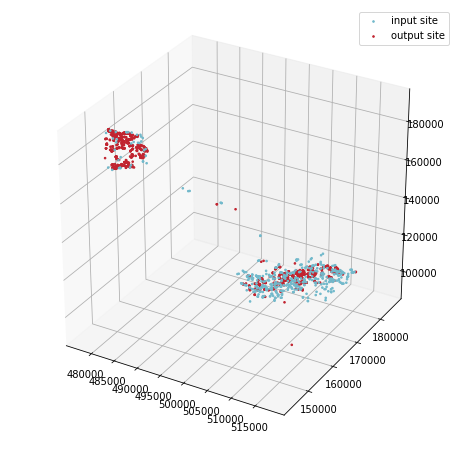

In [4]:
# plot skeleton with pre/post locations in 3d
input_site_color ='#72b9cb'
output_site_color = '#c12430'
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(post_links.post_x, post_links.post_y, post_links.post_z, color=input_site_color, s=2.5, alpha=1.0, label='input site')
ax.scatter(pre_links.pre_x, pre_links.pre_y, pre_links.pre_z, color=output_site_color, s=2.5, alpha=1.0, label='output site')
plt.legend()

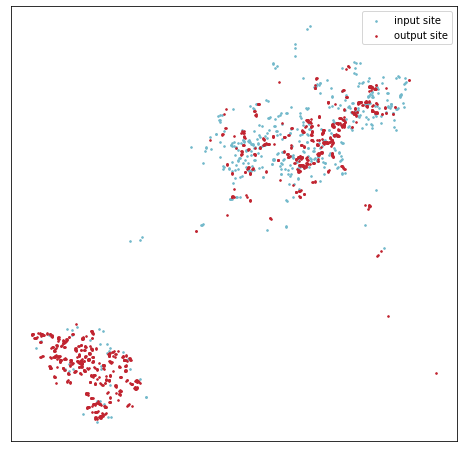

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(post_links.post_x, post_links.post_y,  color=input_site_color, s=2.5, alpha=1.0, label='input site')
ax.scatter(pre_links.pre_x, pre_links.pre_y, color=output_site_color, s=2.5, alpha=1.0, label='output site')
plt.xticks([])
plt.yticks([])
plt.legend()